In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
#!pip 

     |████████████████████████████████| 53 kB 1.3 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o9yf6gvr
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-o9yf6gvr
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=98b0246e7b6b0f617b1a7a3425720f946f1903c356ea4af0f2f80d147290cdb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1uuj0v2/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
!nvidia-smi

Sun May 15 12:15:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
from collections import OrderedDict
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import clip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [137]:
import os
import numpy as np
from tensorflow.keras.utils import load_img

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self):
        pass

    def get_image_single(self, path_to_image):
        """read in a single image, as an np array with dataset dim"""
        img = load_img(path_to_image).convert('RGB') 
        return np.expand_dims(img, 0)

    def get_all_from_artist(self, artist_name):
        """read in images from the prompts: 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation', 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [load_img(f'{self.data_path}/{artist_name}/{img_path}').convert('RGB') 
                         for img_path in all_img_paths  
                         if img_path.endswith('png')]
        return np.array(pond_img_list)


    def get_image_folders(self, data_path, exclude_list, num_artists = None, preprocessor = None):
        """set the path to the data directory
        loop through all artists and load images
        optionally process, eg for clip"""

        self.art_list = []
        self.preprocessed_art_list = []
        self.artist_list = []
        self.data_path = data_path
        self.preprocessor = preprocessor

        if self.data_path[-1] == '/':
            self.data_path = self.data_path[:-1]

        exclude_list.append('.DS_Store')

        self.all_artists = [artist for artist in os.listdir(self.data_path) if artist not in exclude_list]

        if num_artists:
          self.all_artists = self.all_artists[:num_artists]
        for artist in tqdm(self.all_artists):

            for art in self.get_all_from_artist(artist):
                self.artist_list.append(artist)
                self.art_list.append(art)
                if preprocessor:
                    self.preprocessed_art_list.append(self.preprocessor(art))
        
        art_loader.art_list = np.array(art_loader.art_list, dtype=object)
        art_loader.artist_list = np.array(art_loader.artist_list, dtype=object)



    def encode_art_to_features(self, model):
        """turn images into features using a pretrained neural net
        eg clip because thats what most art models use"""

        if self.preprocessor:
          art_array = np.stack(self.preprocessed_art_list)
        else:
          art_array = np.stack(self.art_list)

        image_input = torch.tensor(art_array).cuda()
          
        with torch.no_grad():
            features = model.encode_image(image_input).float()

        return features.cpu().numpy()

In [138]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize


def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    #ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

In [139]:
# Torch - features w clip
print(clip.available_models())

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [75]:
# TF  - fetures w resnet
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Resizing
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.applications.resnet50 import ResNet50

# #tf.keras.applications.resnet50.preprocess_input

# from tensorflow.keras.utils import img_to_array

# #img_to_array()

# topless_resnet = ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
#     pooling='max' #avg, max
# )

# model = Sequential([
#     Resizing(224, 224),
#     topless_resnet
# ])

In [140]:
art_loader = ArtLoader()

# load data

exclude = ['styles single images', 'non-visual artist single images']

art_loader.get_image_folders(data_path = 'drive/My Drive/datasets/artist_studies/batch 1',
                             exclude_list = exclude,
                             num_artists = None, 
                             preprocessor = preprocess)

len(art_loader.all_artists)


clip_features = art_loader.encode_art_to_features(model)


clip_features.shape

  0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 142/142 [01:04<00:00,  2.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56

(912, 512)

In [16]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [307]:
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Resizing

colour_feat_list = []
for art in art_loader.art_list:

  colour_feat_list.append(resize(img_to_array(art), [200,200]))
feat_color_arr = np.stack(colour_feat_list)

colour_features = feat_color_arr.mean(axis = (1, 2))

In [309]:
np.array(colour_feat_list).shape

(912, 200, 200, 3)

In [ ]:
# use conv to extract different colours from the image


In [355]:
# conv to pull out patches of colour
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import L2

def colour_extractor(input_shape):
    input = Input(shape = input_shape)
    conv_output = Conv2D(3, kernel_size = (20, 20), activation = 'relu', strides = (20, 20), padding = 'same')(input)
    output = MaxPooling2D(6)(conv_output)
    model = Model(input, output)
    return model

model = colour_extractor(input_shape = (200, 200, 3))
model.summary()

Model: "model_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_114 (InputLayer)      [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 3)         3603      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 3)          0         
 2D)                                                             
                                                                 
Total params: 3,603
Trainable params: 3,603
Non-trainable params: 0
_________________________________________________________________


In [334]:
np.ones((20, 20)).shape

(20, 20)

In [339]:
red = np.stack([np.ones((20, 20)), np.zeros((20, 20)), np.zeros((20, 20))])
green = np.stack([np.zeros((20, 20)), np.ones((20, 20)), np.zeros((20, 20))])
blue = np.stack([np.zeros((20, 20)), np.zeros((20, 20)), np.ones((20, 20))])

In [343]:
colour_weights = np.stack([red, green, blue]).reshape((20, 20, 3, 3))

In [ ]:
colour_weights[:, :, :, 1]

In [357]:
model.layers[1].get_weights()[0]

array([[[[-6.43595308e-03,  4.69768532e-02,  5.16163185e-03],
         [-3.15726399e-02, -3.37812193e-02, -3.92071828e-02],
         [-2.06490401e-02,  2.69672610e-02,  2.84715183e-02]],

        [[ 1.34504326e-02,  8.26866552e-03, -2.71023996e-02],
         [-1.91633832e-02,  3.86030562e-02, -2.48292927e-02],
         [ 7.04052299e-03,  8.45624134e-03,  1.72110461e-02]],

        [[-2.71978974e-02, -1.89991239e-02,  2.48467214e-02],
         [-4.79259267e-02,  3.22448872e-02, -1.61677599e-03],
         [-4.51583974e-02, -3.18674818e-02,  1.01622567e-02]],

        ...,

        [[-2.08814032e-02,  3.77643220e-02,  2.39175223e-02],
         [-1.13418587e-02, -2.45260242e-02, -3.34384814e-02],
         [-3.14069912e-03,  1.33394711e-02, -3.05132940e-03]],

        [[ 1.12754703e-02,  4.05653566e-03, -4.26157713e-02],
         [-2.43932605e-02, -2.50615012e-02,  2.11871602e-02],
         [ 2.36725546e-02,  4.65026833e-02, -1.38710737e-02]],

        [[ 5.22067398e-03,  2.16240026e-02,  7

In [319]:
ayer_b.set_weights(layer_a)

NameError: ignored

In [ ]:
# getting more colour features, get rgb of top 10 colours in image
# colour order shouldnt matter, features compare them incorrectly
# use conv layer to find colours

In [ ]:
#img_colours = feat_color_arr.reshape(912, -1, 3)

# from sklearn.cluster import KMeans
# k_cluster = KMeans(5)
# img_colours_list = []
# for img in tqdm(img_colours[:300]):
#   print(img.shape)
#   k_cluster.fit(img)

#   colour_feature_list = []
#   for label in np.unique(k_cluster.labels_):
#     colour_feature_list.append(img[k_cluster.labels_ == label].mean(axis = 0))
#     print(colour_feature_list)
#     colour_feature_arr = np.array([feat for feat in colour_feature_list])
#     print(colour_feature_arr)
#     pca_colours = PCA(1)
#     colour_pc = pca_colours.fit_transform(colour_feature_arr)
#     colour_feature_list.append(colour_pc)

#   img_colours_list.append(colour_feature_list)

# many_colour_features = np.stack(img_colours_list)

In [289]:
all_features = np.concatenate((colour_features , clip_features), axis = 1)
all_features.shape

(912, 515)

In [290]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
clip_features_scaled = s_scaler.fit_transform(clip_features)
all_features_scaled = s_scaler.fit_transform(all_features)
# colour_features_scaled = s_scaler.fit_transform(colour_features)
# many_colour_features_scaled = s_scaler.fit_transform(many_colour_features)

In [291]:
#all_features_scaled[:, -3:] = all_features_scaled[:, -3:] * 5

In [292]:
all_features_scaled.shape

(912, 515)

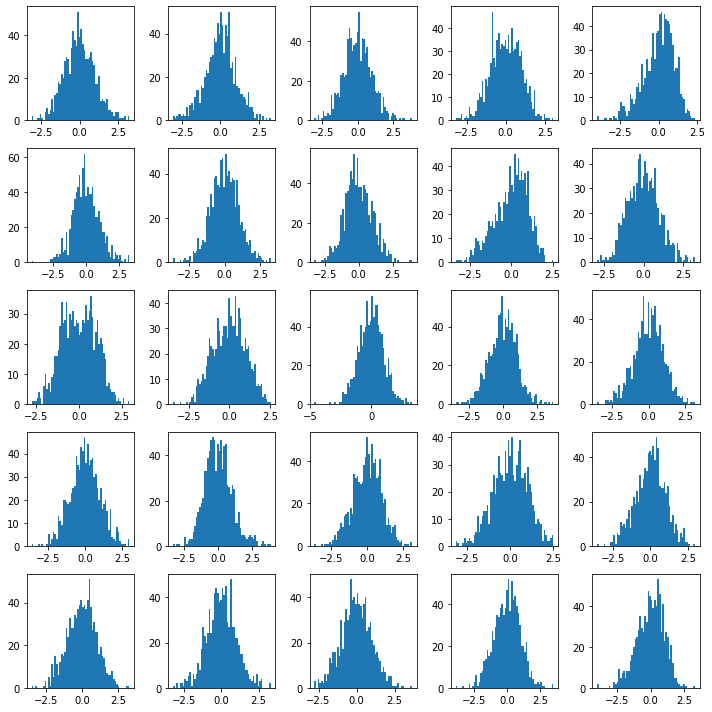

In [293]:
# plot first 25 scaled clip features
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
for ax, i in zip(axes.flat, range(25)):
  ax.hist(all_features_scaled[:, -i], bins = 60);
plt.tight_layout()

In [294]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def split_ponds_buildings(data, artists_list):
  num_pcs = data.shape[-1]
  pca = PCA(num_pcs)
  pcs = pca.fit_transform(data)

  pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
  pcs_dict['artist'] = artists_list

  pcs_df = pd.DataFrame(pcs_dict)
  
  k_cluster = KMeans(2)
  k_cluster.fit(pcs)
  pcs_df['k_labels'] = k_cluster.labels_

  ponds_mask = (pcs_df['k_labels'] == 1).values
  ponds = pcs_df[ponds_mask]

  buildings_mask = (pcs_df['k_labels'] == 0).values
  buildings = pcs_df[buildings_mask]

  plotting_sample = pcs_df.sample(300)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
  sns.scatterplot(data = plotting_sample, x = 'pc1', y = 'pc2', hue = 'artist', ax = ax1)
  ax1.set_title('Before Clustering - by artist')
  ax1.legend('')
  sns.scatterplot(data = plotting_sample, x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax2)
  ax2.set_title('After Kmeans Clustering')
  ax2.legend('')

  return ponds, ponds_mask, buildings, buildings_mask

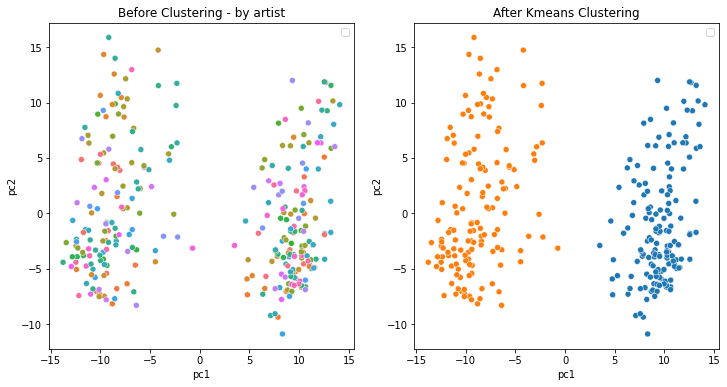

In [295]:
ponds, ponds_mask, buildings, buildings_mask = split_ponds_buildings(all_features_scaled, artists_list = art_loader.artist_list)

In [ ]:
# colour_ponds = colour_features_scaled[ponds_mask]
# colour_buildings = colour_features_scaled[buildings_mask]
# many_colour_ponds = many_colour_features_scaled[ponds_mask]
# many_colour_buildings = many_colour_features_scaled[buildings_mask]

In [83]:
ponds_mask.shape

(912,)

In [296]:
# autoencoder only ponds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import L2

#model = Sequential()

def build_encoder(latent_dim, input_shape):

    input = Input(shape = input_shape)

    x = Dense(64, activation = 'sigmoid')(input)
    #x = Dropout(0.4)(x)
    x = Dense(32, activation = 'sigmoid')(x) # , activity_regularizer=L2(0.1)
    #x = Dropout(0.6)(x)
    output = Dense(latent_dim, activation = 'tanh')(x)

    model = Model(input, output)

    return model

def build_decoder(latent_dim, input_shape):

    input = Input(shape = (latent_dim, ))

    x = Dense(32, activation = 'sigmoid')(input)
    #x = Dropout(0.4)(x)
    x = Dense(64, activation = 'sigmoid')(x)
    #x = Dropout(0.6)(x)
    output = Dense(input_shape[0], activation = 'tanh')(x)

    model = Model(input, output)

    return model


def combine_autoencoder(encoder, decoder, input_shape):
    input_features = Input(shape = input_shape)
    encoded = encoder(input_features)
    decoded = decoder(encoded)
    autoencoder = Model(input_features, decoded)

    autoencoder.compile(loss = 'mse', 
                        optimizer = 'adam',)
    return autoencoder

In [297]:
all_features_scaled.shape

(912, 515)

In [298]:
from tensorflow.keras.callbacks import EarlyStopping

encoder = build_encoder(200, input_shape = (515,))
decoder = build_decoder(200, input_shape = (515,))

autoencoder = combine_autoencoder(encoder, decoder, input_shape = (515,))

es = EarlyStopping(patience = 50, restore_best_weights = True)

history = autoencoder.fit(x = all_features_scaled, y = all_features_scaled, 
            epochs = 1000, 
            batch_size = 32,
            validation_split = 0.2,
            callbacks = [es]).history

Epoch 1/1000
23/23 [==============================] - 1s 12ms/step - loss: 1.0064 - val_loss: 1.0388
Epoch 2/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.9937 - val_loss: 1.0368
Epoch 3/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.9874 - val_loss: 1.0223
Epoch 4/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.9446 - val_loss: 0.9433
Epoch 5/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8628 - val_loss: 0.8858
Epoch 6/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8343 - val_loss: 0.8824
Epoch 7/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8328 - val_loss: 0.8825
Epoch 8/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8333 - val_loss: 0.8822
Epoch 9/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8329 - val_loss: 0.8819
Epoch 10/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.8324 - val_loss: 0.880

0.678855836391449


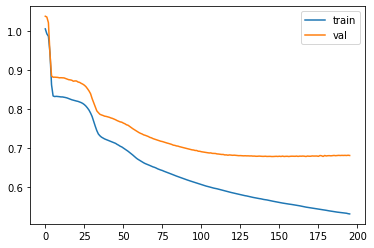

In [299]:
import matplotlib.pyplot as plt
print(min(history['val_loss']))
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend();

In [282]:
ponds.shape

(437, 517)

In [300]:
ponds_encoded = encoder.predict(ponds.iloc[:, :-2].values)
pcs_ponds_dict = {f'pc{i+1}': ponds_encoded[:, i] for i in range(100)}
pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

pcs_ponds_df

# show_xy_images(pcs_ponds_df, imgs = art_loader.art_list[ponds_mask])

pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0    0.378143  0.199658 -0.117254 -0.448868  0.203068  0.749896 -0.171622   
1   -0.055272 -0.125072 -0.029062 -0.497889 -0.161421  0.717437 -0.083410   
2    0.058713 -0.078790 -0.037393 -0.486809 -0.021058  0.767680 -0.098952   
3    0.377300  0.017363 -0.151128  0.211541  0.197173  0.720194 -0.600822   
4    0.423484  0.038788 -0.073200 -0.030993  0.163544  0.595177 -0.317236   
..        ...       ...       ...       ...       ...       ...       ...   
470  0.305205 -0.459541  0.202205  0.262546  0.271205  0.409242  0.095572   
471  0.000756 -0.390939  0.137433  0.011780 -0.129598  0.581558 -0.110194   
472  0.350317 -0.102561  0.299007  0.314267  0.366165  0.594201 -0.445016   
473  0.322905 -0.070847  0.225350  0.240136  0.281664  0.689947 -0.530645   
474  0.362612 -0.020680  0.178090  0.159927  0.329596  0.663781 -0.455081   

          pc8       pc9      pc10  ...      pc92      pc93      pc94  \
0   -0.093560 -0.237560  0.764645  ...  0.581993 -0.429818  0.334103   
1   -0.610519 -0.147720  0.903996  ...  0.266971  0.116145  0.336852   
2   -0.528893 -0.229040  0.896410  ...  0.309632 -0.003446  0.339226   
3   -0.220139  0.135806  0.672323  ... -0.172686 -0.312016  0.047874   
4   -0.343929  0.047351  0.584091  ... -0.240299  0.111364 -0.029555   
..        ...       ...       ...  ...       ...       ...       ...   
470 -0.242194 -0.075741  0.426070  ... -0.336279  0.198451  0.234554   
471 -0.582465  0.055214  0.804356  ... -0.265039  0.239012  0.410886   
472 -0.119491  0.284496  0.273167  ... -0.046866 -0.218702  0.021240   
473 -0.168758  0.275941  0.517042  ...  0.051132 -0.314445  0.038009   
474 -0.099235  0.196571  0.468444  ...  0.062590 -0.288157  0.050673   

         pc95      pc96      pc97      pc98      pc99     pc100  \
0    0.593552 -0.168022 -0.087417 -0.249750 -0.116905 -0.200076   
1    0.164242  0.054984  0.225513  0.153457 -0.053650  0.222528   
2    0.188020  0.025427  0.189960  0.054916 -0.022423  0.047422   
3   -0.091986 -0.031165 -0.352660 -0.546046  0.352060 -0.294606   
4   -0.238677  0.188221 -0.480227 -0.089395  0.328256  0.074019   
..        ...       ...       ...       ...       ...       ...   
470  0.076661  0.332756 -0.202054  0.097158  0.197209  0.359099   
471 -0.158199  0.331106  0.182443  0.083404 -0.034644  0.499063   
472  0.409638  0.113414 -0.431370 -0.412549  0.351914  0.324563   
473  0.406863  0.046893 -0.323276 -0.484537  0.387362  0.143053   
474  0.439524  0.044698 -0.382424 -0.471541  0.333930  0.089327   

                  artist  
0         Copley_William  
1         Copley_William  
2         Copley_William  
3    Arcimboldo_Giuseppe  
4    Arcimboldo_Giuseppe  
..                   ...  
470        Emshwiller_Ed  
471        Emshwiller_Ed  
472        Robert_Hubert  
473        Robert_Hubert  
474        Robert_Hubert  

[475 rows x 101 columns]

In [301]:
# pca only ponds
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(pcs_ponds_df.iloc[:, :-1].values)

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

475it [00:04, 116.20it/s]


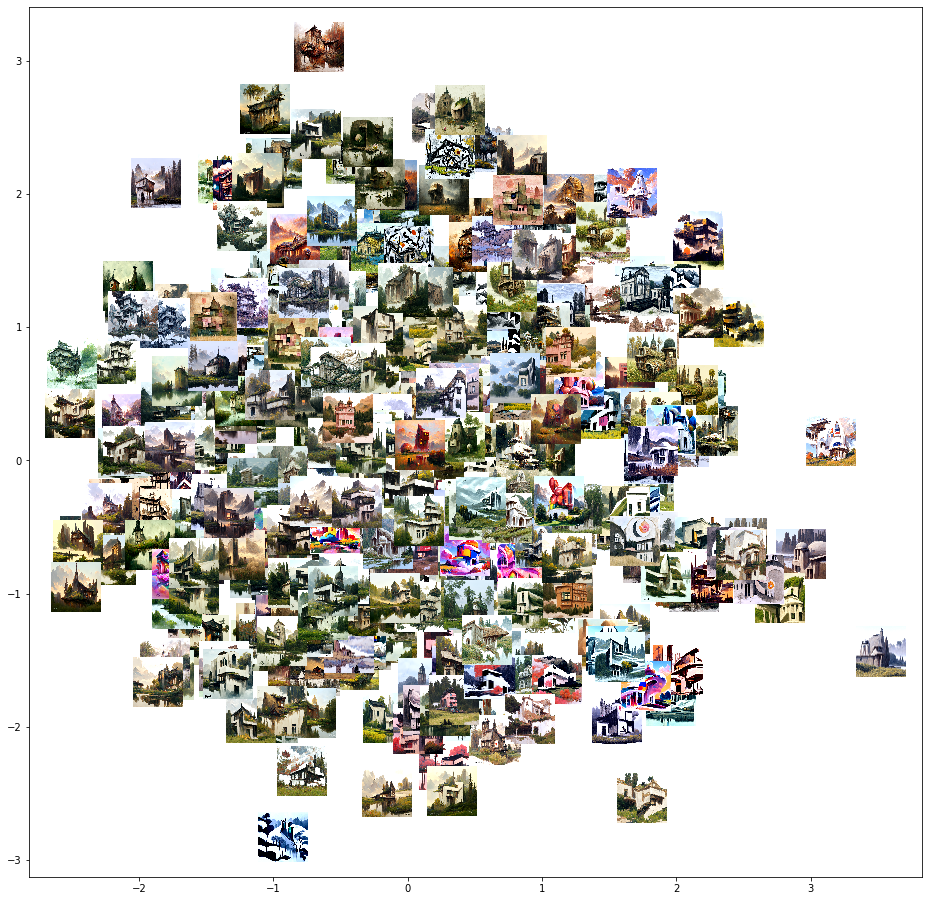

In [302]:
show_xy_images(pcs_ponds_df, imgs = art_loader.art_list[ponds_mask])

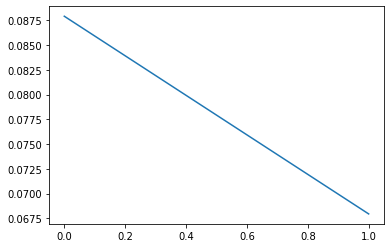

In [88]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# pca only buildings
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_buildings = pca.fit_transform(many_colour_buildings)

pcs_buildings_dict = {f'pc{i+1}': pcs_buildings[:, i] for i in range(num_pcs)}
pcs_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

pcs_buildings_df = pd.DataFrame(pcs_buildings_dict)

In [ ]:
pcs_buildings_df

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# tsne only ponds
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_ponds = tsne.fit_transform(ponds)

tsne_ponds_dict = {f'pc{i+1}': tsne_ponds[:, i] for i in range(num_tsne)}
tsne_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

tsne_ponds_df = pd.DataFrame(tsne_ponds_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
# tsne only buildings
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_buildings = tsne.fit_transform(buildings)

tsne_buildings_dict = {f'pc{i+1}': tsne_buildings[:, i] for i in range(num_tsne)}
tsne_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

tsne_buildings_df = pd.DataFrame(tsne_buildings_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
# import umap

# reducer = umap.UMAP()

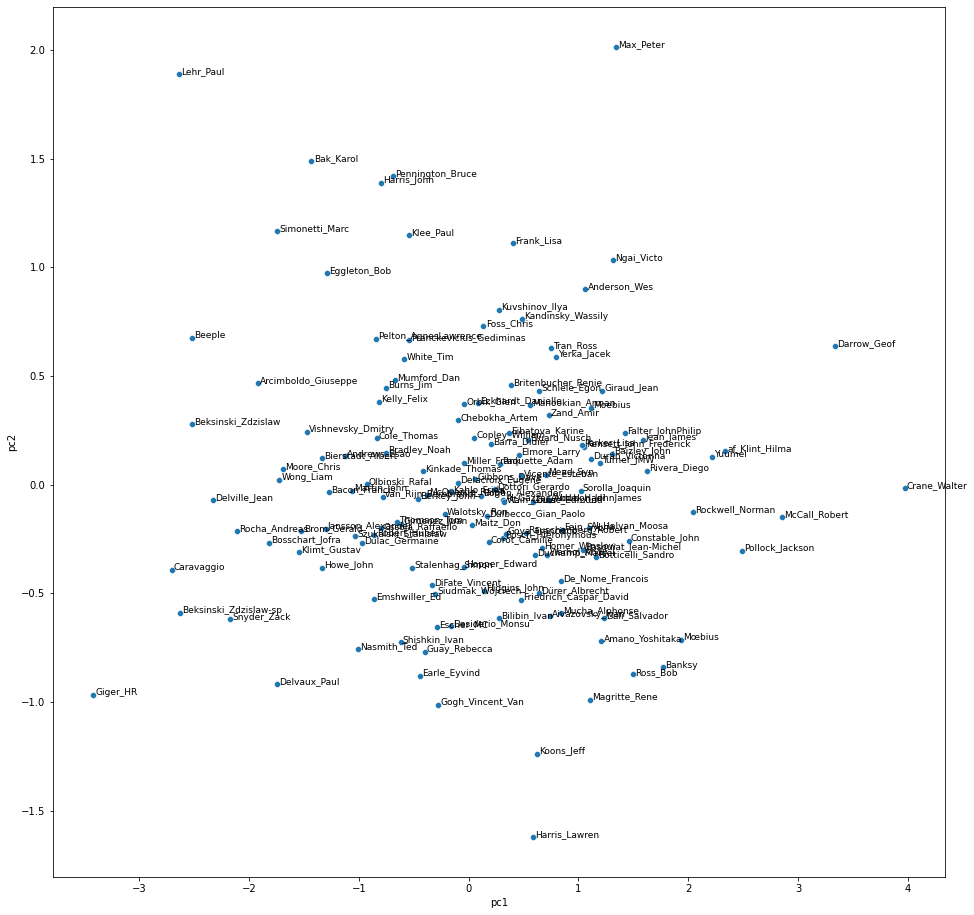

In [ ]:
# create labelled scatterplot
artist_df = pcs_ponds_df.groupby(['artist']).mean().reset_index()

fig , ax = plt.subplots(figsize = (16, 16))
sns.scatterplot(data = artist_df, x = 'pc1', y = 'pc2', ax = ax)

for i, point in artist_df.iterrows():
        ax.text(point['pc1']+.02, point['pc2'], str(point['artist']), size = '9')

In [ ]:
#from tensorflow.keras.utils import array_to_img
#array_to_img(ponds_list[0]).resize((64, 64))

## plotting images onto pc coords

In [122]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize


def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    #ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

475it [00:03, 121.19it/s]


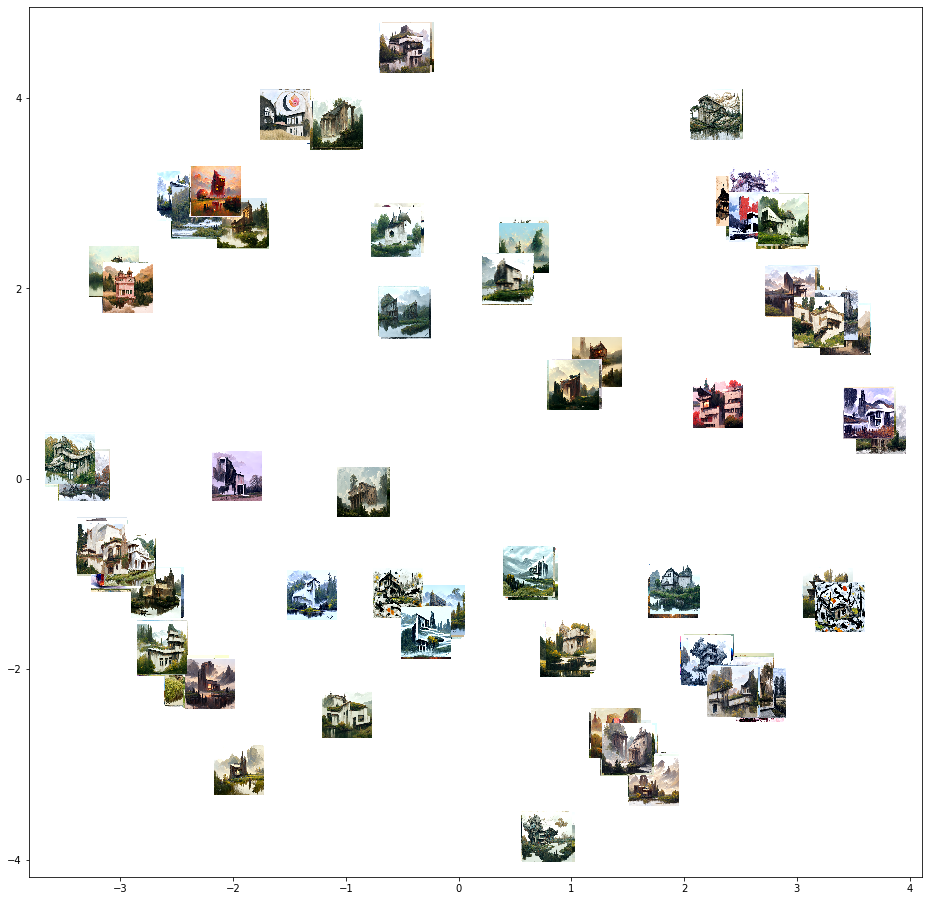

In [ ]:
show_xy_images(pcs_ponds_df, imgs = art_list[ponds_mask])

475it [00:04, 110.78it/s]


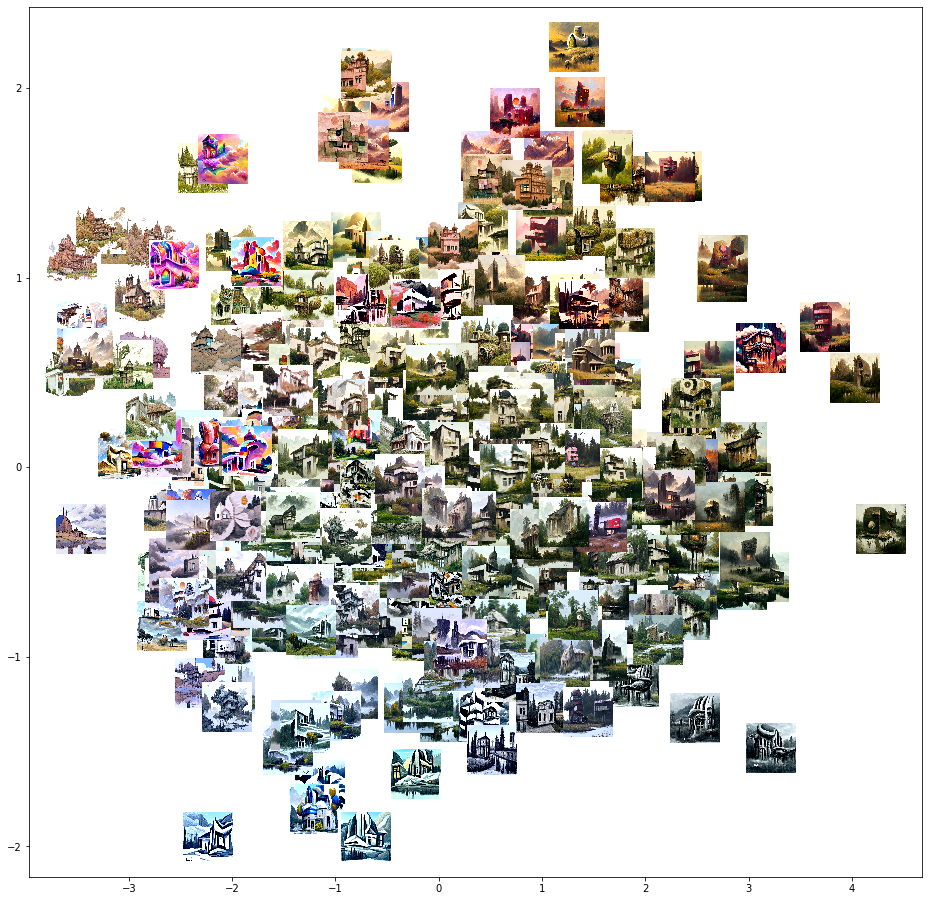

In [ ]:
show_xy_images(pcs_buildings_df, imgs = art_list[buildings_mask])

437it [00:03, 123.81it/s]


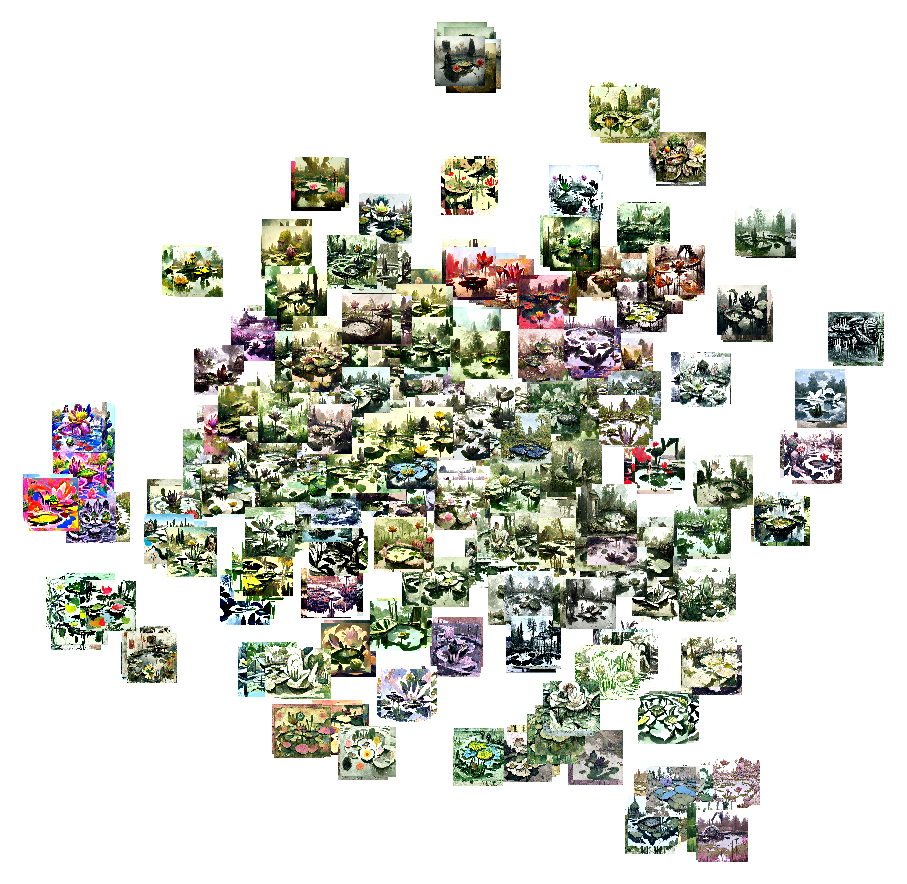

In [ ]:
show_xy_images(tsne_ponds_df, imgs = art_list[ponds_mask])

In [ ]:
show_xy_images(tsne_buildings_df, imgs = art_list[buildings_mask])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [ ]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# preprocess data properly

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [ ]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview

In [ ]:
# def color_count_feature(in_path):
#     raw_image = Image.open(in_path) 
#     web_image = raw_image.convert('P', palette='WEB', dither=None)
#     counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
#     return counts*1.0/np.prod(web_image.size) # normalize output

# image_df['color_features'] = image_df['path'].progress_map(color_count_feature)
